<h3>LLM Architecture</h3>

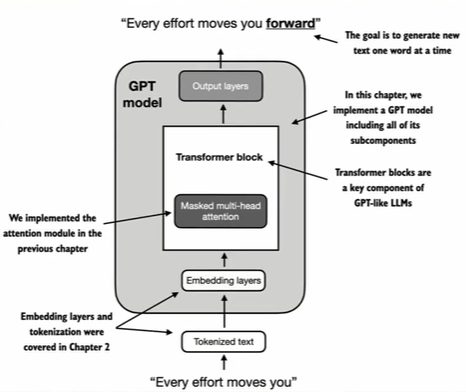

<h3>Transformer architecture</h3>

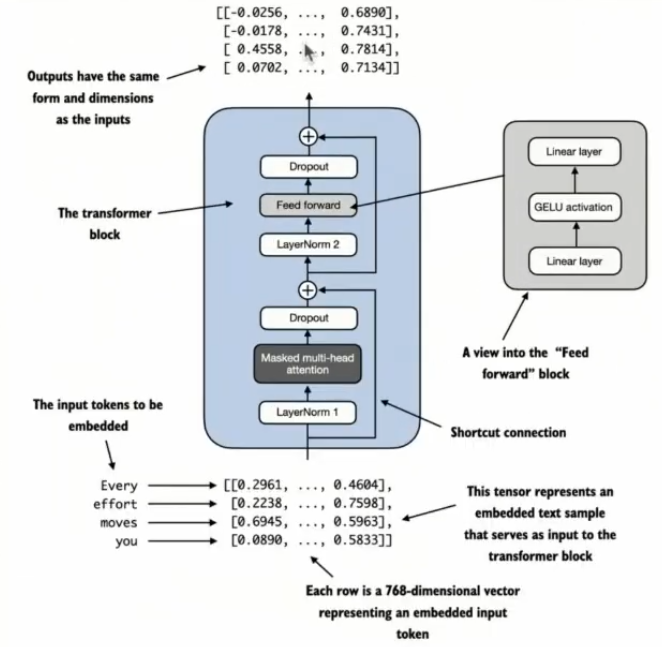


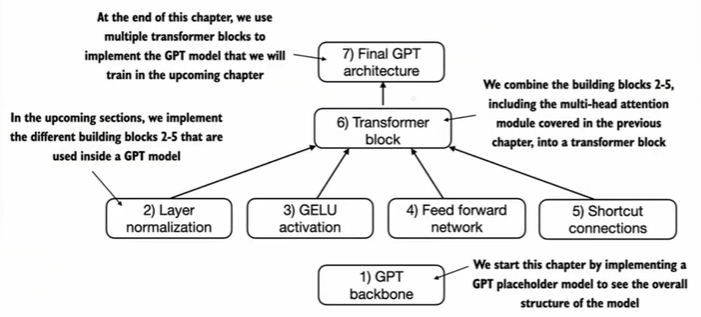

In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

<h1>GPT ARCHITECTURE PART 1: DUMMY GPT MODEL CLASS (Bird's eye view)</h1>

<div style="background-color: #B8B8FF; color: black; padding: 10px">
    Step 1: Use a placeholder for TransformerBlock<br>
    Step 2: Use a placeholder for LayerNorm
</div>

In [3]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

<div style="background-color: #B8B8FF; color: black; padding: 10px">
    <ul>
        <li>The DummyGPTModel class in this code defines a simplified version of a GPT-like model using PyTorch's neural network module (nn.Module).</li>
        <li>The model architecture in the DummyGPTModel class consists of token and positional embeddings, dropout, a series of transformer blocks (DummyTransformerBlock), a final layer normalization (DummyLayerNorm), and a linear output layer (out_head).</li>
        <li>The configuration is passed in via a Python dictionary, for instance, the GPT_CONFIG_124M dictionary we created earlier.</li>
        <li>The forward method describes the data flow through the model: it computes token and positional embeddings for the input indices, applies dropout, processes the data through the transformer blocks, applies normalization, and finally produces logits with the linear output layer.</li>
        <li>The code above is already functional, as we will see later in this section after we prepare the input data.</li>
        <li>However, for now, note in the code above that we have used placeholders (DummyLayerNorm and DummyTransformerBlock) for the transformer block and layer normalization, which we will develop in later sections</li>
    </ul>
</div>

<div style="background-color: #B8B8FF; color: black; padding: 10px">
    Next, we will prepare the input data and initialize a new GPT model to illustrate its usage.
</div>

<h4>STEP 1: TOKENIZATION</h4>

In [4]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


<h4>STEP 2: CREATE AN INSTANCE OF DUMMYGPTMODEL</h4>

In [5]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


<div style="background-color: #B8B8FF; color: black; padding: 10px">
    <ul>
        <li>The output tensor has two rows corresponding to the two text samples. Each text sample consists of 4 tokens; each token is a 50,257-dimensional vector, which matches the size of the tokenizer's vocabulary.</li>
        <li>The embedding has 50,257 dimensions because each of these dimensions refers to a unique token in the vocabulary. At the end of this chapter, when we implement the postprocessing code, we will convert these 50,257-dimensional vectors back into token IDs, which we can then decode into words.</li>
        <li>Each cells of this 50,257-dimensional vector stores probabilities for each word from vocabulary and next word that is predicted will have highest probability in this 50,257-dimensional vector.</li>
    </ul>
</div>

<div style="background-color: #21CC77; color: black; padding: 10px;">
    Now that we have taken a top-down look at the GPT architecture and its in- and outputs, we will code the individual placeholders in the upcoming sections, starting with the real layer normalization class that will replace the DummyLayerNorm in the previous code.
</div>

<h1>GPT ARCHITECTURE PART 2: LAYER NORMALIZATION</h1>

<div style="background-color: #B8B8FF; color: black; padding: 10px">
    <ul>
        <li>Training deep neural networks with many layers can be challenging due to vanishing/exploding gradients.</li>
        <li>This leads to unstable training dynamics.</li>
        <li>Layer normalization improves the stability and efficiency of neural network trainingul.</li>
        <li>If layer output is too large or small, gradient magnitudes can become too large or small. This affects training. Layer normalization keeps gradient stable.</li>
        <li>As the training proceeds, inputs to each layer can change (Internal covariant shift). This delays convergence. Layer normalization prevents this.</li>
        <li><b>Main Idea</b> : Adjust outputs of neural network to have mean equal to zero and variance equal to one. This speeds up the convergence.</li>
        <li>In GPT-2 and modern transformer architectures, layer normalization is typically applied before and after the multi-head attention module and before the final output layer.</li>
    </ul>
</div>

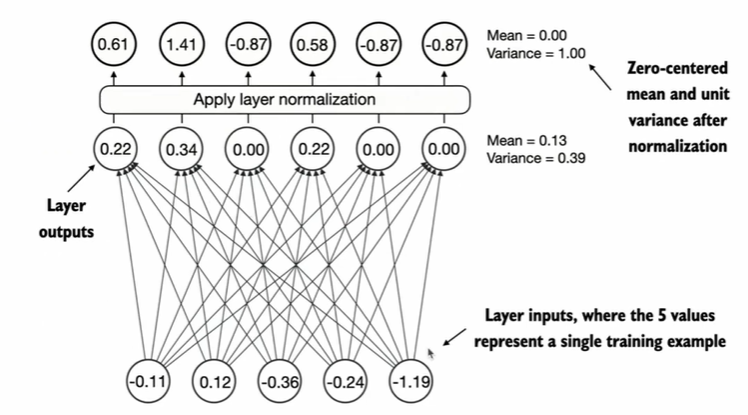

<div style="background-color: #B8B8FF; color: black; padding: 10px">
    Let's take an example. We have 2 batches of inputs and each batch has 5 inputs. We'll pass this two batches to layer of 6 neurons. Which produces 6 outputs for each batch.
</div>

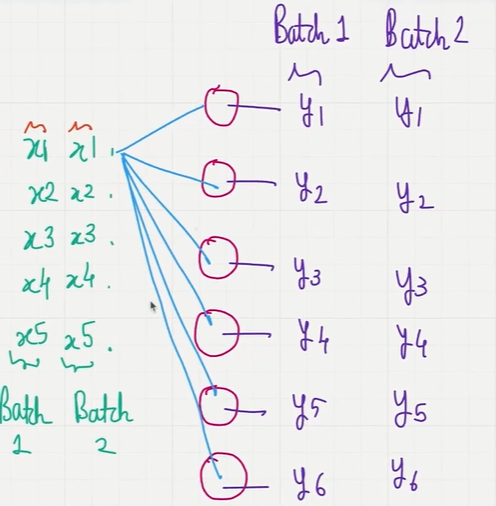

<div style="background-color: #B8B8FF; color: black; padding: 10px">
    As displayed in above image, We'll get two batches of output.
</div>

In [ ]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5) #2 batches and each batch has 5 inputs
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


<div style="background-color: #B8B8FF; color: black; padding: 10px">
    In above code, we have an input. A tensor of sixe 2*5 which means we've 2 batches of inputs and each batch has 5 inputs. Inn output we'll get tensor of size 2*6 which means we'll get 2 batches and each batch has 6 outputs 
</div>

<div style="background-color: #B8B8FF; color: black; padding: 10px">
    <ul>
        <li>The neural network layer we have coded consists of a Linear layer followed by a non-linear activation function, ReLU (short for Rectified Linear Unit), which is a standard activation function in neural networks.</li>
        <li>If you are unfamiliar with ReLU, it simply thresholds negative inputs to 0, ensuring that a layer outputs only positive values, which explains why the resulting layer output does not contain any negative values.</li>
        <li>(Note that we will use another, more sophisticated activation function in GPT, which we will introduce in the next section).</li>
    </ul> 
<div>

<div style="background-color: #B8B8FF; color: black; padding: 10px">
    Before we apply layer normalization to these outputs, let's examine the mean and variance:
</div>

In [15]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


<div style="background-color: #B8B8FF; color: black; padding: 10px">
    <ul>
        <li>The first row in the mean tensor above contains the mean value for the first input row, and the second output row contains the mean for the second input row.</li>
        <li>Using keepdim=True in operations like mean or variance calculation ensures that the output tensor retains the same number of dimensions as the input tensor, even though the operation reduces the tensor along the dimension specified via dim.</li>
        <li>For instance, without keepdim=True, the returned mean tensor would be a 2-dimensional vector [0.1324, 0.2170] instead of a 2×1-dimensional matrix [[0.1324], [0.2170]].</li>
        <li>For a 2D tensor (like a matrix), using dim=-1 for operations such as mean or variance calculation is the same as using dim=1.</li>
        <li>This is because -1 refers to the tensor's last dimension, which corresponds to the columns in a 2D tensor.</li>
        <li>Later, when adding layer normalization to the GPT model, which produces 3D tensors with shape [batch_size, num_tokens, embedding_size], we can still use dim=-1 for normalization across the last dimension, avoiding a change from dim=1 to dim=2.</li>
    </ul>
</div>

<div style="background-color: #B8B8FF; color: black; padding: 10px">
    Next, let us apply layer normalization to the layer outputs we obtained earlier. The operation consists of subtracting the mean and dividing by the square root of the variance (also known as standard deviation):
</div>

In [16]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [0.0000e+00]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


<div style="background-color: #B8B8FF; color: black; padding: 10px">
    Note that the value 9.9341e-09 in the output tensor is the scientific notation for 9.9341 × 10-9, which is 0.0000000099341 in decimal form. This value is very close to 0, but it is not exactly 0 due to small numerical errors that can accumulate because of the finite precision with which computers represent numbers.
</div>

<div style="background-color: #B8B8FF; color: black; padding: 10px">
    To improve readability, we can also turn off the scientific notation when printing tensor values by setting sci_mode to False:
</div>

In [17]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


<div style="background-color: #B8B8FF; color: black; padding: 10px">
    Let's now encapsulate this process in a PyTorch module that we can use in the GPT model later:
</div>

In [22]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

<div style="background-color: #B8B8FF; color: black; padding: 10px">
    <ul>
        <li>This specific implementation of layer Normalization operates on the last dimension of the input tensor x, which represents the embedding dimension (emb_dim).</li>
        <li>The variable eps is a small constant (epsilon) added to the variance to prevent division by zero during normalization.</li>
        <li>The scale and shift are two trainable parameters (of the same dimension as the input) that the LLM automatically adjusts during training if it is determined that doing so would improve the model's performance on its training task.</li>
        <li>This allows the model to learn appropriate scaling and shifting that best suit the data it is processing.</li>
    </ul>
</div>

<div style="background-color: #21CC77; color: black; padding: 10px;">
    A small note on biased variance:<br>
    <ul>
        <li>In our variance calculation method, we have opted for an implementation detail by setting unbiased=False. For those curious about what this means, in the variance calculation, we divide by the number of inputs n in the variance formula.</li>
        <li>This approach does not apply Bessel's correction, which typically uses n-1 instead of n in the denominator to adjust for bias in sample variance estimation.</li>
        <li>This decision results in a so-called biased estimate of the variance.</li>
        <li>For large-scale language models (LLMs), where the embedding dimension n is significantly large, the difference between using n and n-1 is practically negligible.</li>
        <li>We chose this approach to ensure compatibility with the GPT-2 model's normalization layers and because it reflects TensorFlow's default behavior, which was used to implement the original GPT2 model.</li>
    </ul>
</div>

In [23]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


<div style="background-color: #B8B8FF; color: black; padding: 10px">
    As we can see based on the results, the layer normalization code works as expected and normalizes the values of each of the two inputs such that they have a mean of 0 and a variance of 1:
</div>

<div style="background-color: #B8B8FF; color: black; padding: 10px">
    Difference between Layer normalization vs Batch normalization :<br>
    <ul>
        <li>Batch normalization is not that feasible as it depends on batch size. And batch size depends on available hardware. If numbe rof hardware is less than you have to reduce batch size.</li>
        <li>Layer normalizatuon leads to more flexibility and stability for distributed training (environment which lack resources).</li>
    </ul>
</div>

<div style="background-color: #21CC77; color: black; padding: 10px;">
    Summary of layer normalization:<br>
    <ul>
        <li>In trnsormer block Layer Normalization is applied (2 times in one block) to the inputs so that mean of each embedding vectors (of token) should be 0 and variance should be 1.</li>
        <li>Normalization formula : <b>(x - mean) / torch.sqrt(var + self.eps)</b></li>
        <li>self.scale * norm_x + self.shift, Here scale and shift is also applied to normalized embedding vector which are trainable parameters.</li>
    </ul>
</div>